In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from skimage.color import rgb2lab
from skimage.util import img_as_float
from scipy.stats import skew, kurtosis

import xgboost as xgb

In [14]:
!curl -L -o ./skin-cancer-malignant-vs-benign.zip\
  https://www.kaggle.com/api/v1/datasets/download/fanconic/skin-cancer-malignant-vs-benign

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  324M  100  324M    0     0  79.8M      0  0:00:04  0:00:04 --:--:--  100M


In [15]:
if not os.path.exists('model'):
    os.makedirs('model')

In [17]:
!unzip skin-cancer-malignant-vs-benign.zip

Archive:  skin-cancer-malignant-vs-benign.zip
replace data/test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Train classes: ['malignant', 'benign']
Test classes: ['malignant', 'benign']


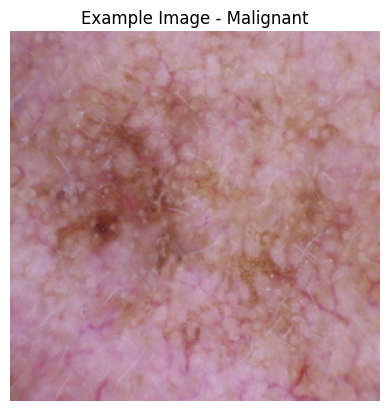

In [19]:
train_dir = 'train'
test_dir = 'test'

print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))

sample_path = os.path.join(train_dir, 'malignant', '991.jpg')
image = cv2.imread(sample_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title("Example Image - Malignant")
plt.axis('off')
plt.show()

In [20]:
target_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory='test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [21]:
def extract_color_features(images):
    features = []
    for img in images:
        img = img_as_float(img)
        if np.isnan(img).any() or np.isinf(img).any():
            continue

        lab = rgb2lab(img)
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        # Moments
        l_mean, l_std = np.mean(L), np.std(L)
        l_skew, l_kurt = skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std = np.mean(A), np.std(A)
        a_skew, a_kurt = skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std = np.mean(B), np.std(B)
        b_skew, b_kurt = skew(B.flatten()), kurtosis(B.flatten())

        # Histograms
        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        # Combine features
        moments = np.array([
            l_mean, l_std, l_skew, l_kurt,
            a_mean, a_std, a_skew, a_kurt,
            b_mean, b_std, b_skew, b_kurt
        ])
        hist_features = np.concatenate([l_hist, a_hist, b_hist])
        final_vector = np.concatenate([moments, hist_features])
        features.append(final_vector)

    return np.array(features)

In [22]:
def extract_features_from_generator(generator, num_samples):
    all_features = []
    all_labels = []
    steps = int(np.ceil(num_samples / generator.batch_size))

    for _ in range(steps):
        imgs, labels = next(generator)
        batch_features = extract_color_features(imgs)
        all_features.append(batch_features)
        all_labels.append(labels)

    return np.vstack(all_features), np.concatenate(all_labels)

# Extract
num_train = train_generator.n
num_test = test_generator.n

print("Extracting training features...")
X_train, y_train = extract_features_from_generator(train_generator, num_train)

print("Extracting testing features...")
X_test, y_test = extract_features_from_generator(test_generator, num_test)

Extracting training features...
Extracting testing features...


In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
clf = xgb.XGBClassifier(
    random_state=42,
    max_depth=10,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss'
)
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:09:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Test Accuracy: 87.27%


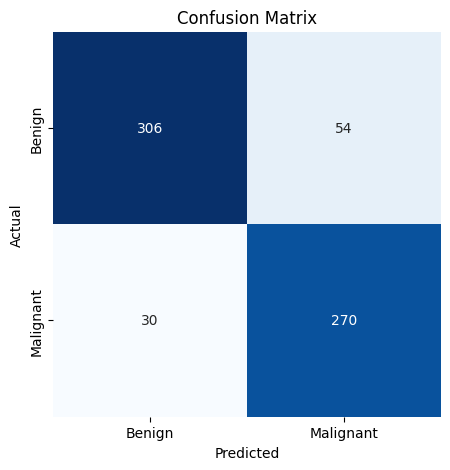

              precision    recall  f1-score   support

      Benign       0.91      0.85      0.88       360
   Malignant       0.83      0.90      0.87       300

    accuracy                           0.87       660
   macro avg       0.87      0.88      0.87       660
weighted avg       0.88      0.87      0.87       660



In [25]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))